# Chameleon Cast - Iteration 2.5: Animated Frame Conditioning

This iteration improves on Iteration 2 by:
1. Extracting first and last frames from original video
2. Converting them to animated style using Gemini 3 Pro Image
3. Using the animated frames as start/end constraints for Veo

This ensures both the beginning and end are properly animated.

In [ ]:
!pip install -q -U google-generativeai
!pip install opencv-python-headless pillow matplotlib

In [ ]:
import google.generativeai as genai
from google.colab import userdata, files as colab_files
from google import genai as genai_client
from google.genai import types
import time
import json
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)
client = genai_client.Client(api_key=GOOGLE_API_KEY)

## Step 1: Upload Your Video

In [ ]:
# Upload video file
print("Please upload your video file:")
uploaded = colab_files.upload()

# Get the uploaded filename
video_filename = list(uploaded.keys())[0]
print(f"\n✅ Uploaded: {video_filename}")

# Rename to video.mp4 for consistency
!mv "{video_filename}" video.mp4
print("Renamed to video.mp4")

Please upload your video file:


Saving video (7) (online-video-cutter.com).mp4 to video (7) (online-video-cutter.com).mp4

✅ Uploaded: video (7) (online-video-cutter.com).mp4
Renamed to video.mp4


In [ ]:
# Upload the video to Gemini
print("Uploading video to Gemini...")
video_file = genai.upload_file(path="video.mp4")

# Wait for processing
print("Waiting for video to be processed...")
while video_file.state.name == "PROCESSING":
    time.sleep(2)
    video_file = genai.get_file(video_file.name)

if video_file.state.name == "FAILED":
    raise ValueError(f"Video processing failed: {video_file.state.name}")

print(f"Video is ready! State: {video_file.state.name}")

Uploading video to Gemini...
Waiting for video to be processed...
Video is ready! State: ACTIVE


## Step 2: Extract First and Last Frames

Video info: 60.00 fps, 1554 frames, 25.90s duration
✓ Extracted frame at 0.00s (frame 0)
✓ Extracted frame at 25.80s (frame 1547)


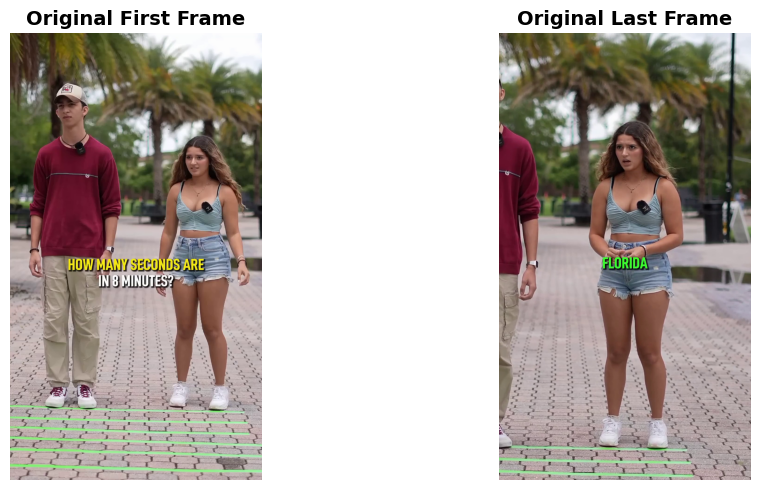

In [ ]:
def extract_frames(video_path, frame_times=None):
    """
    Extract frames at specific times from video.
    """
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps

    print(f"Video info: {fps:.2f} fps, {total_frames} frames, {duration:.2f}s duration")

    if frame_times is None:
        # Default: first and last frame
        frame_times = [0, duration - 0.1]

    frames = []
    for time_sec in frame_times:
        frame_number = int(time_sec * fps)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        success, frame = cap.read()

        if success:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_image = Image.fromarray(frame_rgb)
            frames.append(pil_image)
            print(f"✓ Extracted frame at {time_sec:.2f}s (frame {frame_number})")
        else:
            print(f"✗ Failed to extract frame at {time_sec:.2f}s")

    cap.release()
    return frames

# Extract first and last frames
frames = extract_frames('video.mp4')
first_frame = frames[0]
last_frame = frames[1]

# Save frames
first_frame.save('first_frame.png')
last_frame.save('last_frame.png')

# Display frames
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(first_frame)
axes[0].set_title('Original First Frame', fontsize=14, fontweight='bold')
axes[0].axis('off')
axes[1].imshow(last_frame)
axes[1].set_title('Original Last Frame', fontsize=14, fontweight='bold')
axes[1].axis('off')
plt.tight_layout()
plt.show()

## Step 3: Extract Structured JSON Description

In [ ]:
model = genai.GenerativeModel('gemini-2.5-flash-lite')

json_prompt = """Analyze this video and return a JSON structure describing it for animation generation.

IMPORTANT: Return ONLY valid JSON, no markdown code blocks or extra text.

Use this exact structure:
{
  "style": {
    "animation_type": "string (e.g., Pixar 3D, Disney 2D, stop-motion)",
    "color_palette": "string describing colors",
    "mood": "string describing tone/feeling"
  },
  "scene": {
    "setting": "string describing location",
    "lighting": "string describing light quality",
    "camera": "string describing camera angles/movement"
  },
  "characters": [
    {
      "species": "animated animal species",
      "appearance": "physical description and clothing",
      "personality": "character traits shown"
    }
  ],
  "actions": [
    {
      "timestamp": "time range (e.g., 0-2s)",
      "description": "what happens in this segment",
      "camera_focus": "what the camera emphasizes"
    }
  ],
  "audio_cues": [
    "list of important sounds or dialogue"
  ]
}

Requirements:
- Replace all humans with appropriate animated animal characters
- Keep the same actions and energy
- Make it suitable for Pixar/Disney style animation
- Break down actions into 2-second segments
- Return ONLY the JSON, nothing else
"""

response = model.generate_content([json_prompt, video_file])
response_text = response.text.strip()

# Clean up response
if response_text.startswith('```json'):
    response_text = response_text.replace('```json', '').replace('```', '').strip()
elif response_text.startswith('```'):
    response_text = response_text.replace('```', '').strip()

print("Raw JSON Response:")
print(response_text)
print("\n" + "="*50 + "\n")

Raw JSON Response:
{
  "style": {
    "animation_type": "Pixar 3D",
    "color_palette": "Bright and naturalistic with warm tones, highlighting green foliage and earthy paving stones.",
    "mood": "Playful, energetic, and slightly competitive."
  },
  "scene": {
    "setting": "An outdoor paved walkway with palm trees and buildings in the background.",
    "lighting": "Bright, sunny daylight with dappled shadows.",
    "camera": "Medium shots, occasional close-ups on faces and the ground markings, a slight zoom out at the end."
  },
  "characters": [
    {
      "species": "Young Fox",
      "appearance": "Wearing a maroon long-sleeved shirt, beige cargo pants, a baseball cap, and white sneakers.",
      "personality": "Confident, thoughtful, trying to appear knowledgeable."
    },
    {
      "species": "Young Deer",
      "appearance": "Wearing a light blue crop top, distressed denim shorts, and white sneakers. She has curly brown hair.",
      "personality": "Enthusiastic, expressi

In [ ]:
try:
    video_json = json.loads(response_text)
    print("✅ JSON parsed successfully!\n")
    print(json.dumps(video_json, indent=2))
except json.JSONDecodeError as e:
    print(f"❌ JSON parsing failed: {e}")
    print("Attempting to fix...")
    import re
    json_match = re.search(r'\{.*\}', response_text, re.DOTALL)
    if json_match:
        video_json = json.loads(json_match.group())
        print("✅ JSON extracted and parsed!\n")
        print(json.dumps(video_json, indent=2))
    else:
        raise

✅ JSON parsed successfully!

{
  "style": {
    "animation_type": "Pixar 3D",
    "color_palette": "Bright and naturalistic with warm tones, highlighting green foliage and earthy paving stones.",
    "mood": "Playful, energetic, and slightly competitive."
  },
  "scene": {
    "setting": "An outdoor paved walkway with palm trees and buildings in the background.",
    "lighting": "Bright, sunny daylight with dappled shadows.",
    "camera": "Medium shots, occasional close-ups on faces and the ground markings, a slight zoom out at the end."
  },
  "characters": [
    {
      "species": "Young Fox",
      "appearance": "Wearing a maroon long-sleeved shirt, beige cargo pants, a baseball cap, and white sneakers.",
      "personality": "Confident, thoughtful, trying to appear knowledgeable."
    },
    {
      "species": "Young Deer",
      "appearance": "Wearing a light blue crop top, distressed denim shorts, and white sneakers. She has curly brown hair.",
      "personality": "Enthusiastic

## Step 4: Convert Frames to Animated Style with Imagen

In [ ]:
print("Converting frames to animated style with Imagen...\n")

# Build character description from JSON
characters_desc = ', '.join([
    f"{c.get('species', 'animal')} wearing {c.get('appearance', 'clothing')}"
    for c in video_json.get('characters', [])
])

# Create prompts for frame conversion
frame_conversion_prompt = f"""
Convert this image to {video_json['style']['animation_type']} style.
Characters: {characters_desc}
Setting: {video_json['scene']['setting']}
Style: {video_json['style']['color_palette']}, {video_json['style']['mood']} mood.
Keep the EXACT same poses, positions, camera angle, and composition.
Maintain all spatial relationships between characters and objects.
"""

print("Conversion prompt:")
print(frame_conversion_prompt)
print("\n" + "="*50 + "\n")

Converting frames to animated style with Imagen...

Conversion prompt:

Convert this image to Pixar 3D style.
Characters: Young Fox wearing Wearing a maroon long-sleeved shirt, beige cargo pants, a baseball cap, and white sneakers., Young Deer wearing Wearing a light blue crop top, distressed denim shorts, and white sneakers. She has curly brown hair.
Setting: An outdoor paved walkway with palm trees and buildings in the background.
Style: Bright and naturalistic with warm tones, highlighting green foliage and earthy paving stones., Playful, energetic, and slightly competitive. mood.
Keep the EXACT same poses, positions, camera angle, and composition.
Maintain all spatial relationships between characters and objects.





Converting first frame to animated with Gemini 3 Pro...
✅ First frame animated



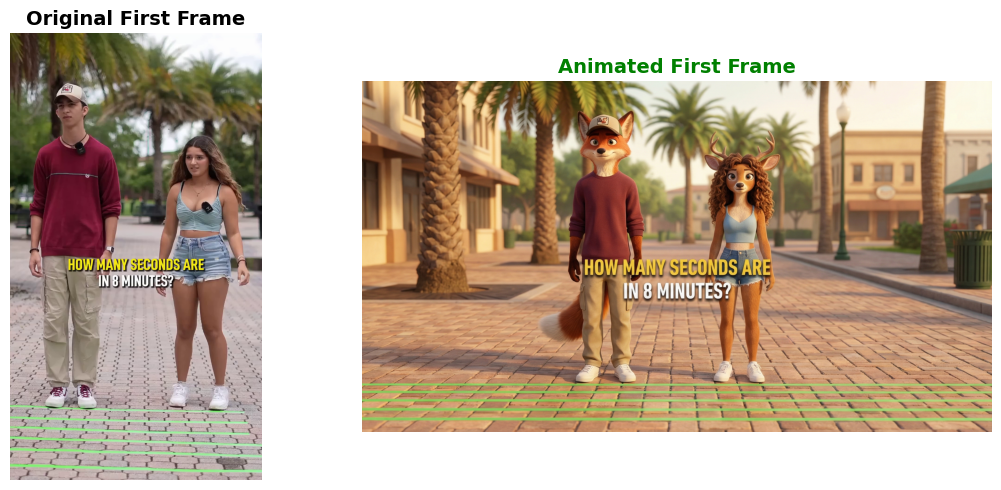

In [ ]:
# Convert FIRST frame to animated using Gemini 3 Pro Image
print("Converting first frame to animated with Gemini 3 Pro...")

first_frame_pil = Image.open('first_frame.png')

animated_first_response = client.models.generate_content(
    model='gemini-3-pro-image-preview',  # Use Pro model
    contents=[frame_conversion_prompt, first_frame_pil],
    config=types.GenerateContentConfig(
        response_modalities=['IMAGE'],  # Only want image output
        image_config=types.ImageConfig(
            aspect_ratio='16:9',  # Match original
            image_size='2K'  # Higher quality
        )
    )
)

# Extract the generated image
for part in animated_first_response.parts:
    if part.inline_data is not None:
        animated_first_image = part.as_image()
        animated_first_image.save('animated_first_frame.png')
        print("✅ First frame animated\n")

# Display
first_animated_pil = Image.open('animated_first_frame.png')
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(first_frame)
axes[0].set_title('Original First Frame', fontsize=14, fontweight='bold')
axes[0].axis('off')
axes[1].imshow(first_animated_pil)
axes[1].set_title('Animated First Frame', fontsize=14, fontweight='bold', color='green')
axes[1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Convert LAST frame to animated using Gemini 3 Pro Image
print("Converting last frame to animated with Gemini 3 Pro...")

last_frame_pil = Image.open('last_frame.png')

animated_last_response = client.models.generate_content(
    model='gemini-3-pro-image-preview',  # Use Pro model
    contents=[frame_conversion_prompt, last_frame_pil],
    config=types.GenerateContentConfig(
        response_modalities=['IMAGE'],  # Only want image output
        image_config=types.ImageConfig(
            aspect_ratio='16:9',  # Match original
            image_size='2K'  # Higher quality
        )
    )
)

# Extract the generated image
for part in animated_last_response.parts:
    if part.inline_data is not None:
        animated_last_image = part.as_image()
        animated_last_image.save('animated_last_frame.png')
        print("✅ Last frame animated\n")

# Display comparison
last_animated_pil = Image.open('animated_last_frame.png')
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(last_frame)
axes[0].set_title('Original Last Frame', fontsize=14, fontweight='bold')
axes[0].axis('off')
axes[1].imshow(last_animated_pil)
axes[1].set_title('Animated Last Frame', fontsize=14, fontweight='bold', color='green')
axes[1].axis('off')
plt.tight_layout()
plt.show()

Converting last frame to animated with Gemini 3 Pro...


ClientError: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_requests_per_model_per_day, limit: 0', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_requests_per_model_per_day', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel'}]}]}}

## Step 5: Build Video Generation Prompt

In [ ]:
def json_to_prompt(video_json):
    """Convert structured JSON to a detailed video generation prompt"""

    # Build style description
    style = video_json.get('style', {})
    style_desc = f"{style.get('animation_type', 'Animated')} with {style.get('color_palette', 'vibrant colors')}. {style.get('mood', 'Energetic')} mood."

    # Build scene description
    scene = video_json.get('scene', {})
    scene_desc = f"Scene: {scene.get('setting', 'outdoor setting')} with {scene.get('lighting', 'natural lighting')}. Camera: {scene.get('camera', 'dynamic angles')}."

    # Build character descriptions
    characters = video_json.get('characters', [])
    char_desc = "Characters: " + ", ".join([
        f"{c.get('species', 'animal')} ({c.get('appearance', 'colorful')})"
        for c in characters
    ])

    # Build action sequence
    actions = video_json.get('actions', [])
    action_desc = "Action sequence: " + " ".join([
        f"[{a.get('timestamp', '')}] {a.get('description', '')}."
        for a in actions
    ])

    # Combine into final prompt
    final_prompt = f"{style_desc} {scene_desc} {char_desc} {action_desc}"

    return final_prompt

veo_prompt = json_to_prompt(video_json)
print("Generated Veo Prompt:")
print("="*50)
print(veo_prompt)
print("="*50)

Generated Veo Prompt:
Pixar 3D with Bright blues for the court, vibrant greens and reds for player outfits, clear blue sky. Energetic, competitive, exciting mood. Scene: A brightly lit outdoor tennis court with the word 'MELBOURNE' prominently displayed on the blue surface. Bleachers with spectators are visible in the background. with Bright, sunny, high-contrast daylight. Camera: Dynamic aerial shots, fast pans, and zooms following the ball and players. Characters: Penguin (A sleek, athletic penguin wearing a sharp red tennis outfit and white sneakers. Has expressive eyes and a determined posture.), Gazelle (A lithe gazelle in a green and white tennis outfit, also with athletic sneakers. Features elegant, quick movements.), Gorilla (A strong, muscular gorilla in a grey tennis shirt and dark shorts, with white sneakers. Carries a confident air.) Action sequence: [0-2s] The gorilla serves the ball with a powerful overhead swing. The gazelle prepares to receive.. [2-4s] The gazelle retur

## Step 6: Generate Video with Veo Using Animated Frames

Now we pass the **animated** first and last frames to Veo using the `image` + `last_frame` parameters.

In [ ]:
print("Generating video with Veo 3.1...")
print(f"Using animated first and last frames as constraints\n")

# Read animated frames as bytes and create Image objects
with open('animated_first_frame.png', 'rb') as f:
    first_bytes = f.read()

with open('animated_last_frame.png', 'rb') as f:
    last_bytes = f.read()

# Create Image objects
first_image_obj = types.Image(
    image_bytes=first_bytes,
    mime_type="image/png"
)

last_image_obj = types.Image(
    image_bytes=last_bytes,
    mime_type="image/png"
)

# Generate video with first and last frame constraints
operation = client.models.generate_videos(
    model="veo-3.1-generate-preview",
    prompt=veo_prompt,
    image=first_image_obj,  # Starting frame (animated)
    config=types.GenerateVideosConfig(
        last_frame=last_image_obj,  # Ending frame (animated)
        number_of_videos=1,
        resolution="720p"
    )
)

# Wait for completion
while not operation.done:
    print("Waiting for video generation to complete...")
    time.sleep(10)
    operation = client.operations.get(operation)

# Download result
generated_video = operation.response.generated_videos[0]
client.files.download(file=generated_video.video)
generated_video.video.save("iteration2_5_output.mp4")
print("\n✅ Generated video saved to iteration2_5_output.mp4")

Generating video with Veo 3.1...
Using animated first and last frames as constraints

Waiting for video generation to complete...
Waiting for video generation to complete...
Waiting for video generation to complete...
Waiting for video generation to complete...
Waiting for video generation to complete...

✅ Generated video saved to iteration2_5_output.mp4
